In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import mmd as md
import gene_extractor as ge

%matplotlib inline

#### Get Data (you might need to change the flie path)

In [10]:
#get raw data
f = h5py.File('./datasets/18_01_24_pilot_triplets.hdf5', 'r')
data_x_raw = np.array(f.get('x'))
data_y_raw = np.array(f.get('y'))

f.close()

#get single interaction pairs (204 type)
#data_x1, data_y1 = ge.extract_data(2,0,4,data_x_raw, data_y_raw)
data_x2, data_y2 = ge.extract_data(0,0,1,data_x_raw, data_y_raw)

In [15]:
mmds = []

In [16]:
# data_x1.shape, data_x2.shape
for i in range(1000):
    d1 = data_x2[np.random.randint(0, len(data_x2)-1, 2000)].astype(np.float64)
    d2 = data_x2[np.random.randint(0, len(data_x2)-1, 2000)].astype(np.float64)
    mmd = sess.run(md.rbf_mmd2(d1, d2))
    mmds.append(mmd)
    print (i, mmd)

0 0.00100854585128
1 0.00101922936222
2 0.000981175763593
3 0.000983656531309
4 0.000977184792764
5 0.00102883511973
6 0.00110667605239
7 0.000962075486245
8 0.00102651236133
9 0.000915301997907
10 0.00095406664679
11 0.000972586656353
12 0.000975601681507
13 0.000950263105296
14 0.000994038955818
15 0.00100177764435
16 0.000944517928267
17 0.0010290853747
18 0.000948140143919
19 0.000971653331321
20 0.00106866382853
21 0.00104281712691
22 0.000935244580685
23 0.00103158948293
24 0.000952137902323
25 0.00123730473689
26 0.00109987772051
27 0.000979923579607
28 0.000930986602974
29 0.00104044254393
30 0.000971590736972
31 0.000976526180245
32 0.00101551467768
33 0.00102283033117
34 0.000959316750423
35 0.000948322668354
36 0.000957418532252
37 0.00099324993839
38 0.000978367494639
39 0.00104348233604
40 0.00101709015246
41 0.000943610959746
42 0.00101714427212
43 0.000970267051448
44 0.000998627759331
45 0.000976328850877
46 0.00102739873863
47 0.000987452002739
48 0.00107853836327
49 0

KeyboardInterrupt: 

{'boxes': [<matplotlib.lines.Line2D at 0x1d3a21e2e80>],
 'caps': [<matplotlib.lines.Line2D at 0x1d3a21ee8d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d3a21f3588>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d3a21f3160>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1d3a21e2fd0>,
  <matplotlib.lines.Line2D at 0x1d3a21ee4a8>]}

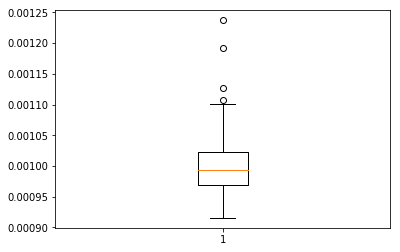

In [20]:
plt.boxplot(mmds)

In [21]:
np.mean(mmds)

0.00099981785703612031

In [25]:
np.max(mmds)

0.0012373047368898736

In [85]:
# data_x1 = data_x1[np.random.randint(0, len(data_x1), 2000)]
data_x2 = data_x2[np.random.randint(0, 85196, 20000)]

In [117]:
# #find mmd between 001 and 204 triplets
# sess = tf.Session()
# differ = sess.run(md.mix_rbf_mmd2(data_x1.astype(np.float64), data_x2.astype(np.float64)))
# differ

In [86]:
data_x1 = data_x2

In [87]:
data_x1.shape

(20000, 10, 3)

In [88]:
data_x1.max()

0.67335296

In [89]:
#data scaling
range_x1 = data_x1.max() - data_x1.min()
data_x1 = 2*((data_x1 - data_x1.min())/range_x1) -1

(array([   8309.,   13933.,   12262.,   14779.,   23189.,   38263.,
          46084.,   76924.,  229769.,  136488.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

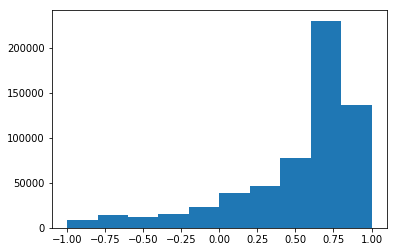

In [90]:
plt.hist(np.reshape(data_x1, [-1,1]), bins=10)

In [91]:
data_x1.min(), data_x1.max()

(-1.0, 1.0)

In [105]:
#hyperparams
batch_size = 128
hidden_units_d = 30
hidden_units_g = 30
num_features = 3
time_seq = 10
epochs = 10000
no_of_batches = data_x1.shape[0]//batch_size

In [106]:
tf.reset_default_graph()

#### create discriminator

In [107]:
init_x = tf.contrib.layers.xavier_initializer()

#discriminator
x_d = tf.placeholder(tf.float32,[None, time_seq, num_features])
# y_d = tf.placeholder(tf.float32, [None, 1])

w_d_1 = tf.get_variable(name = 'w_d_1', shape=[hidden_units_d*time_seq, hidden_units_d], dtype=tf.float32, initializer=init_x)
b_d_1 = tf.Variable(tf.zeros([hidden_units_d]))

w_d_2 = tf.get_variable(name = 'w_d_2', shape =[hidden_units_d, 1], dtype=tf.float32, initializer=init_x)
b_d_2 = tf.Variable(tf.zeros([1]))


lstm_d = tf.contrib.rnn.BasicLSTMCell(hidden_units_d)

In [108]:
def discriminator(x):
    with tf.variable_scope('d') as dis_scope:
        output_d, state_d = tf.nn.dynamic_rnn(lstm_d, x, dtype=tf.float32)  
        
    output_d = tf.reshape(output_d, [-1, hidden_units_d*time_seq ])
    out_d_1 = tf.nn.tanh(tf.matmul(output_d, w_d_1) + b_d_1)
    out_d_2 = tf.nn.sigmoid(tf.matmul(out_d_1, w_d_2) + b_d_2)
      
    return out_d_2

#### create generator

In [109]:
#generator
z_g = tf.placeholder(tf.float32, [None, time_seq, num_features])

w_g_1 = tf.get_variable(name = 'w_g_1', shape=[hidden_units_g, 100], dtype=tf.float32, initializer=init_x)
b_g_1 = tf.Variable(tf.zeros([100]))

w_g_2 = tf.get_variable(name = 'w_g_2', shape=[100, num_features], dtype=tf.float32, initializer=init_x)
b_g_2 = tf.Variable(tf.zeros([num_features]))


lstm_g = tf.contrib.rnn.BasicLSTMCell(hidden_units_g)

In [110]:
def generator(z):
    with tf.variable_scope('g') as gen_scope:
        output_g, state_g = tf.nn.dynamic_rnn(lstm_g, z, dtype=tf.float32)
    
    output_g_2d = tf.reshape(output_g, [-1, hidden_units_g])
    
    out_g_1 = tf.nn.tanh(tf.matmul(output_g_2d, w_g_1) + b_g_1)
    out_g_final = 1.5*tf.reshape(tf.nn.tanh(tf.matmul(out_g_1, w_g_2) +b_g_2), [-1, time_seq, num_features])
    
    return out_g_final

In [111]:
#losses
loss_d = -tf.reduce_mean(tf.log(discriminator(x_d)) + tf.log(1-discriminator(generator(z_g))))
loss_g = -tf.reduce_mean(tf.log(discriminator(generator(z_g))))

In [112]:
#random sampling function
def sample(l,m,n):
    return np.random.randn(l,m,n)

In [113]:
d_vars = [v for v in tf.global_variables() if v.name.startswith('d')]
g_vars = [v for v in tf.global_variables() if v.name.startswith('g')]
d_vars.extend([w_d_1, b_d_1, w_d_2, b_d_2])
g_vars.extend([w_g_1, b_g_1, w_g_2, b_g_2])

solver_d = tf.train.AdamOptimizer().minimize(loss_d, var_list = d_vars)
solver_g = tf.train.AdamOptimizer().minimize(loss_g, var_list = g_vars)

In [114]:
#sample
g_sample = generator(z_g)
d_test = discriminator(x_d)
g_test = discriminator(generator(z_g))

In [115]:
def plot(samples):
    fig = plt.figure(figsize = (4,4))
    gs = gridspec.GridSpec(4,4)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.plot(sample)
    
    return fig

In [4]:
sess = tf.Session()

In [117]:
sess.run(tf.global_variables_initializer())

## !! Avalanche this !!

In [118]:
losses = []
mmds = []

random_sample = sample(16,time_seq,num_features)

for i in range(epochs):
    ptr = 0
    for j in range(no_of_batches):
        x_train = data_x1[ptr:ptr+batch_size]
        ptr+=batch_size
        _, G_curr_loss = sess.run([solver_g, loss_g], feed_dict = {z_g: sample((batch_size), time_seq,num_features)})
        _, D_curr_loss = sess.run([solver_d, loss_d], feed_dict = {x_d: x_train, z_g: sample(batch_size, time_seq,num_features)})

    losses.append((D_curr_loss, G_curr_loss))
    
    #print loss every 50 epochs
    if (i%100 == 0):
        fig = plot(sess.run(g_sample, feed_dict={z_g :random_sample}))
        plt.savefig('out_lstm_gan/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        plt.close(fig)
        
        data_test = data_x1[np.random.randint(0,len(data_x1),1000)].astype(np.float64)
        gen_test = tf.cast(sess.run(g_sample, feed_dict={z_g:sample(1000,time_seq,num_features)}), tf.float64)
        
        mmd_1 = sess.run(md.rbf_mmd2(data_test, gen_test, sigma=1))
#         mmd_10 = sess.run(md.rbf_mmd2(data_test, gen_test, sigma=10))
        mmds.append(mmd_1)
        
#         fig = plt.plot(mmds)
#         plt.savefig('out_lstm_gan_mmd/{}.png'.format(str(i)))
#         plt.close(fig)
        
        print('Result:')
        print(D_curr_loss, G_curr_loss, mmd_1)

Result:
1.026 1.49511 0.931643377173
Result:
1.59559 0.711977 0.280771083861
Result:
1.39864 0.699447 0.0853813915541
Result:
1.14783 0.952845 0.100343165832
Result:
1.30565 0.621896 0.0591788805064
Result:
1.38629 0.693145 0.517859542036
Result:
1.29733 0.834942 0.0876250870772
Result:
1.38416 0.691288 0.377761517339
Result:
1.38629 0.693235 0.157159209507
Result:
1.38836 0.694844 0.0539146122248
Result:
1.38626 0.693161 0.0799796423701
Result:
1.3569 0.734999 0.0274921737261
Result:
1.38585 0.704357 0.302855888719
Result:
1.34228 0.829234 0.114078432399
Result:
1.35108 0.739426 0.0236265520774
Result:
1.3845 0.693273 0.204897736259
Result:
1.29573 0.75853 0.0317160982639
Result:
1.22729 0.775637 0.170850358573
Result:
1.37956 0.693468 0.0304429624391
Result:
1.29704 0.88899 0.0265921302268
Result:
1.31371 0.633878 0.112473137596
Result:
1.38636 0.69287 0.0809563582761
Result:
1.31022 0.940629 0.11316204162
Result:
1.38629 0.693726 0.117005594504
Result:
1.3387 0.79368 0.0395334473243

KeyboardInterrupt: 

In [138]:
sess.close()

In [ ]:
md.rbf_mmd2()

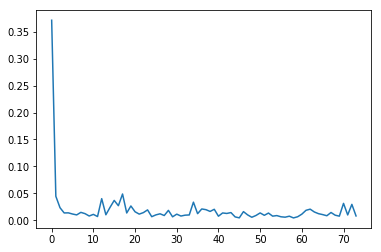

In [142]:
a = plt.plot(mmds)

In [145]:
print(mmds)

[nan]


In [5]:
plt.plot(losses)
plt.axis([0,2000, 0, 2.5])

NameError: name 'losses' is not defined

In [82]:
import csv

with open('log_mmd.csv', 'a') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(mmds)

with open('log_losses.csv', 'a') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(losses)

In [207]:
z_test = sample(40,10,2)
result = sess.run([d_test, g_test], feed_dict={x_d: data_x[0:40], z_g: z_test})

In [209]:
result[1]

array([[ 0.01161301],
       [ 0.01165897],
       [ 0.01161724],
       [ 0.01161953],
       [ 0.01162852],
       [ 0.01157659],
       [ 0.01161788],
       [ 0.011531  ],
       [ 0.01167002],
       [ 0.01161905],
       [ 0.01162146],
       [ 0.01138993],
       [ 0.01163033],
       [ 0.01162347],
       [ 0.01166212],
       [ 0.01162827],
       [ 0.01165409],
       [ 0.01167269],
       [ 0.0116739 ],
       [ 0.01165302],
       [ 0.01161776],
       [ 0.01162956],
       [ 0.01162906],
       [ 0.01163028],
       [ 0.01167026],
       [ 0.01161545],
       [ 0.01163079],
       [ 0.0111618 ],
       [ 0.01162934],
       [ 0.01162987],
       [ 0.0114429 ],
       [ 0.01120971],
       [ 0.01162324],
       [ 0.01161592],
       [ 0.01166446],
       [ 0.01161963],
       [ 0.01163019],
       [ 0.01120325],
       [ 0.01166916],
       [ 0.01167322]], dtype=float32)

In [156]:
l = sess.run(tf.trainable_variables())

In [165]:
count = 0
for i in l:
    print(i.shape)

(40, 1)
(1,)
(16, 2)
(2,)
(6, 16)
(16,)
(18, 64)
(64,)


In [166]:
(40) +1 + 32 + 2+ (16*6) + 16 + (18*64) + 64

1403

In [245]:
weights = sess.run(w_g_2)

([array([ 2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  3.,  0.,  1.,
          0.,  1.,  0.,  0.,  1.,  1.,  1.]),
  array([ 1.,  2.,  2.,  3.,  0.,  1.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,
          0.,  1.,  0.,  0.,  1.,  0.,  0.])],
 array([-0.56689072, -0.50974732, -0.45260392, -0.39546053, -0.33831713,
        -0.28117374, -0.22403034, -0.16688694, -0.10974355, -0.05260015,
         0.00454324,  0.06168664,  0.11883004,  0.17597343,  0.23311683,
         0.29026023,  0.34740362,  0.40454702,  0.46169041,  0.51883381,
         0.57597721]),
 <a list of 2 Lists of Patches objects>)

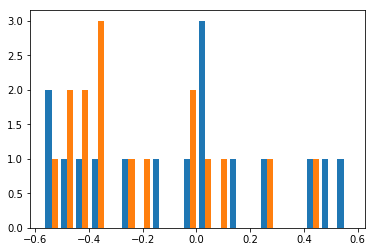

In [246]:
plt.hist(weights, bins = 20)

In [247]:
weights.shape

(16, 2)

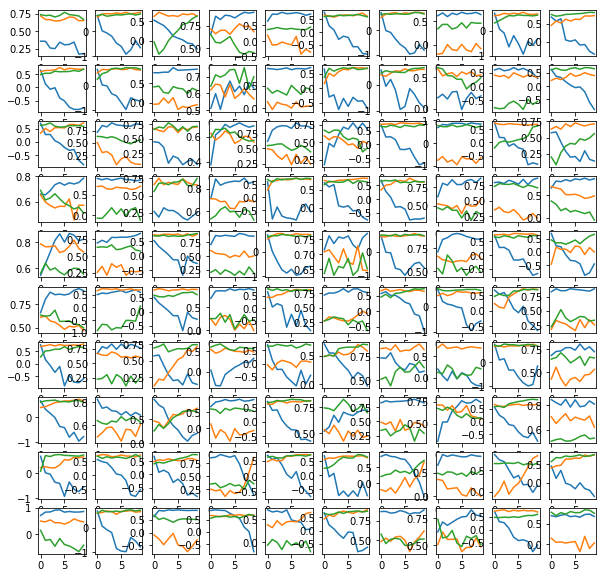

In [25]:
#plot 100 random samples from data_x
fig = plt.figure(figsize = (10,10))
gs = gridspec.GridSpec(10,10)

for i, x in enumerate(data_x1[np.random.randint(0, len(data_x1), 100)]):
    ax = plt.subplot(gs[i])
    plt.plot(x)

In [28]:
#plot 100 random samples from z
fig = plt.figure(figsize = (10,10))
gs = gridspec.GridSpec(10,10)

for i, x in enumerate(generated_data[np.random.randint(0,2500,100)]):
    ax = plt.subplot(gs[i])
    plt.plot(x)

NameError: name 'generated_data' is not defined

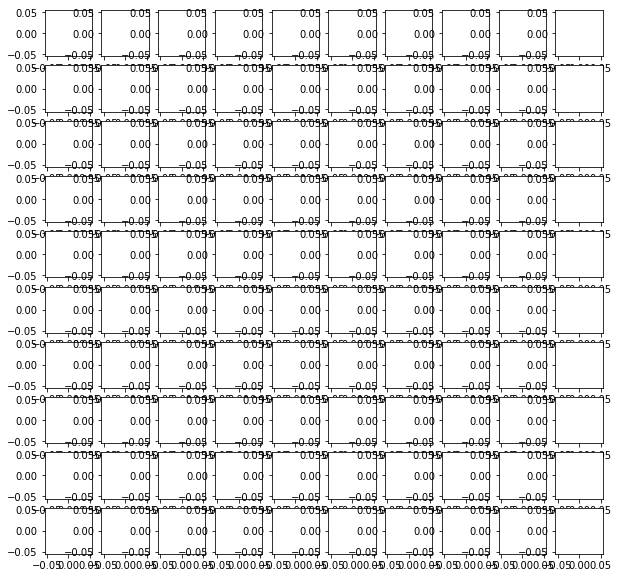

In [143]:
#plot 100 random samples from z
fig = plt.figure(figsize = (10,10))
gs = gridspec.GridSpec(10,10)

for i, x in enumerate(sess.run(g_sample, feed_dict={z_g: sample(100,10,3)})):
    ax = plt.subplot(gs[i])
    plt.plot(x)

In [14]:
a = data_x1[a1 ,:,:]

In [13]:
a1 = np.random.randint(0, 20000, 100)

In [448]:
b = data_x[a1]

In [384]:
data_x_raw_lin = np.reshape(data_x_raw, [-1,1])

In [434]:
data_x_raw.min()

-9.9650927

In [443]:
ran_x = data_x.max() - data_x.min()

In [444]:
data_x = 2*((data_x - data_x.min())/ran_x) -1

In [451]:
data_x.shape

(85197, 10, 2)

In [633]:
a.shape

(100, 10, 1)

In [634]:
b = sess.run(generator(z_g), feed_dict={z_g: sample(100,10,1)})

In [635]:
b.shape

(100, 10, 1)

[-1, 1, 0, 100000]

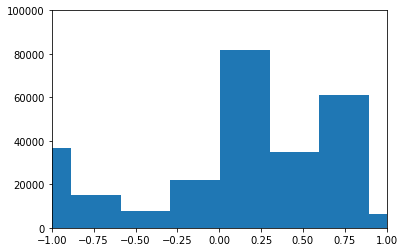

In [72]:
plt.hist(np.reshape(sess.run(generator(z_g), feed_dict={z_g: sample(10000,10,3)}), [-1,1]))
plt.axis([-1,1,0,100000])

[-1, 1, 0, 100000]

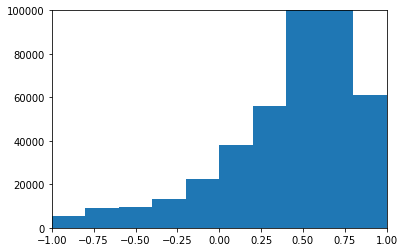

In [73]:
plt.hist((np.reshape(data_x1, [-1,1])))
plt.axis([-1,1,0,100000])

In [30]:
plt.hist(np.reshape(sess.run(generator(z_g), feed_dict={z_g: sample(10000,10,1)}), [-1,1]))
plt.axis([-1,1,0,100000])

ValueError: Cannot feed value of shape (10000, 10, 1) for Tensor 'Placeholder_1:0', which has shape '(?, 10, 15)'

In [734]:
saver = tf.train.Saver()

In [738]:
saver.save(sess, './my-test-model')

FailedPreconditionError: Attempting to use uninitialized value beta1_power_2
	 [[Node: save_1/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/SaveV2/tensor_names, save_1/SaveV2/shape_and_slices, Variable, Variable_1, Variable_2, beta1_power, beta1_power_1, beta1_power_2, beta2_power, beta2_power_1, beta2_power_2, d/rnn/basic_lstm_cell/bias, d/rnn/basic_lstm_cell/bias/Adam, d/rnn/basic_lstm_cell/bias/Adam_1, d/rnn/basic_lstm_cell/kernel, d/rnn/basic_lstm_cell/kernel/Adam, d/rnn/basic_lstm_cell/kernel/Adam_1, g/rnn/basic_lstm_cell/bias, g/rnn/basic_lstm_cell/bias/Adam, g/rnn/basic_lstm_cell/bias/Adam_1, g/rnn/basic_lstm_cell/kernel, g/rnn/basic_lstm_cell/kernel/Adam, g/rnn/basic_lstm_cell/kernel/Adam_1, w_d_1, w_g_1, w_g_2)]]

Caused by op 'save_1/SaveV2', defined at:
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-734-18da33d742f9>", line 1, in <module>
    saver = tf.train.Saver()
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1218, in __init__
    self.build()
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 748, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 296, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 239, in save_op
    tensors)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1162, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\jindalk\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta1_power_2
	 [[Node: save_1/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/SaveV2/tensor_names, save_1/SaveV2/shape_and_slices, Variable, Variable_1, Variable_2, beta1_power, beta1_power_1, beta1_power_2, beta2_power, beta2_power_1, beta2_power_2, d/rnn/basic_lstm_cell/bias, d/rnn/basic_lstm_cell/bias/Adam, d/rnn/basic_lstm_cell/bias/Adam_1, d/rnn/basic_lstm_cell/kernel, d/rnn/basic_lstm_cell/kernel/Adam, d/rnn/basic_lstm_cell/kernel/Adam_1, g/rnn/basic_lstm_cell/bias, g/rnn/basic_lstm_cell/bias/Adam, g/rnn/basic_lstm_cell/bias/Adam_1, g/rnn/basic_lstm_cell/kernel, g/rnn/basic_lstm_cell/kernel/Adam, g/rnn/basic_lstm_cell/kernel/Adam_1, w_d_1, w_g_1, w_g_2)]]


In [744]:
d_vars.append(w_d_1)

In [746]:
d_vars.append(b_d_1)

In [748]:
g_vars.append(w_g_1)

In [750]:
g_vars.extend([b_g_1, w_g_2, b_g_2])

In [775]:
g_vars

[<tf.Variable 'g/rnn/basic_lstm_cell/kernel:0' shape=(25, 96) dtype=float32_ref>,
 <tf.Variable 'g/rnn/basic_lstm_cell/bias:0' shape=(96,) dtype=float32_ref>,
 <tf.Variable 'w_g_1:0' shape=(24, 24) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(24,) dtype=float32_ref>,
 <tf.Variable 'w_g_2:0' shape=(24, 2) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(2,) dtype=float32_ref>]

In [776]:
d_vars

[<tf.Variable 'd/rnn/basic_lstm_cell/kernel:0' shape=(7, 20) dtype=float32_ref>,
 <tf.Variable 'd/rnn/basic_lstm_cell/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'w_d_1:0' shape=(50, 1) dtype=float32_ref>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32_ref>]

In [904]:
x1 = np.random.randn(1000,10,2)

In [905]:
x2 = np.random.random([1000,10,2])

In [37]:
#generate data to pack into hdf5
generated_data = sess.run(generator(z_g), feed_dict={z_g: sample(5000, 10, 3)})

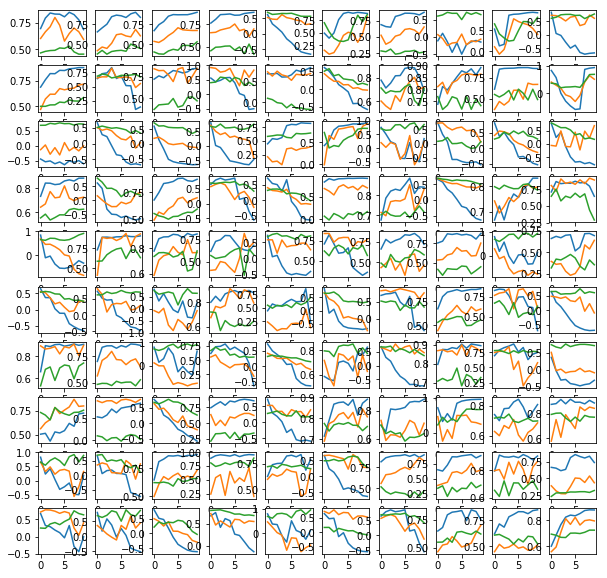

In [41]:
#plot 25 random samples from z
fig = plt.figure(figsize = (10,10))
gs = gridspec.GridSpec(10,10)

for i, x in enumerate(generated_data[np.random.randint(0,5000,100)]):
    ax = plt.subplot(gs[i])
    plt.plot(x)

In [50]:
#data scaling
range_generated_data = generated_data.max() - generated_data.min()
generated_data_scaled = (data_x.max() - data_x.min())*((generated_data - generated_data.min())/range_generated_data) + data_x.min()

In [53]:
generated_data_scaled.shape

(5000, 10, 3)

(array([  1326.,   5456.,   3460.,   3963.,   5740.,   8426.,  14692.,
         28267.,  48327.,  30343.]),
 array([-9.96509266, -8.90124807, -7.83740349, -6.7735589 , -5.70971432,
        -4.64586973, -3.58202515, -2.51818056, -1.45433598, -0.39049139,
         0.6733532 ]),
 <a list of 10 Patch objects>)

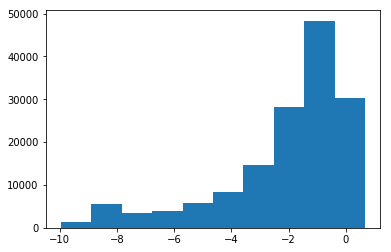

In [52]:
plt.hist(np.reshape(generated_data_scaled, [-1,1]))

In [56]:
generated_data_scaled = np.transpose(generated_data_scaled, axes=[0,2,1])

In [64]:
generated_data_labels = np.transpose(np.array([np.ones([5000]), np.zeros([5000]), np.zeros([5000])]))

In [66]:
generated_data_labels

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [70]:
#write generated data
f = h5py.File('./datasets/18_01_24_pilot_triplets_generated.hdf5', 'w')
f.create_dataset('x', data=generated_data_scaled)
f.create_dataset('y', data=generated_data_labels)

f.close()

In [74]:
generated_data_scaled[0][1]

array([-0.82297802, -0.95761585, -0.78582573, -1.12882805, -0.55225468,
       -1.57706261, -0.35262775, -0.59710693, -1.34418201, -0.36601925], dtype=float32)